### Import 

In [17]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

In [21]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] 

# training config:
epochs = 10
batch_size = 32

#define paths
covid_path = 'data/chest/Chest_COVID'
noncovid_path = 'data/chest/Chest_NonCOVID'

# Use glob to grab images from path .jpg 
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

### Fetch Images and Class Labels from Files 

In [22]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

### Visualize First 40 Images from Data set

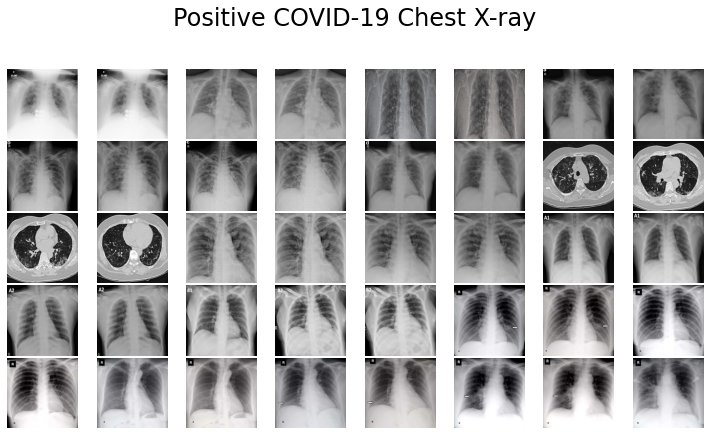

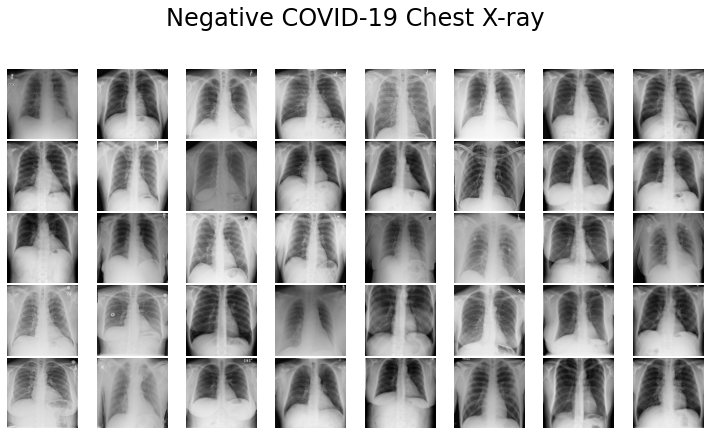

In [23]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

### **Normalization**


In [24]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [25]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

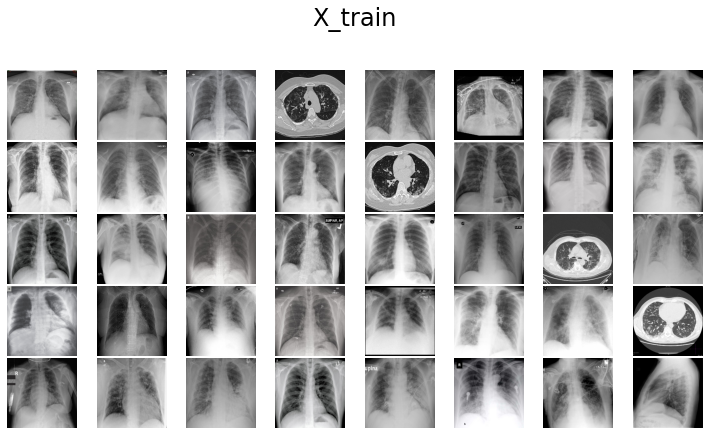

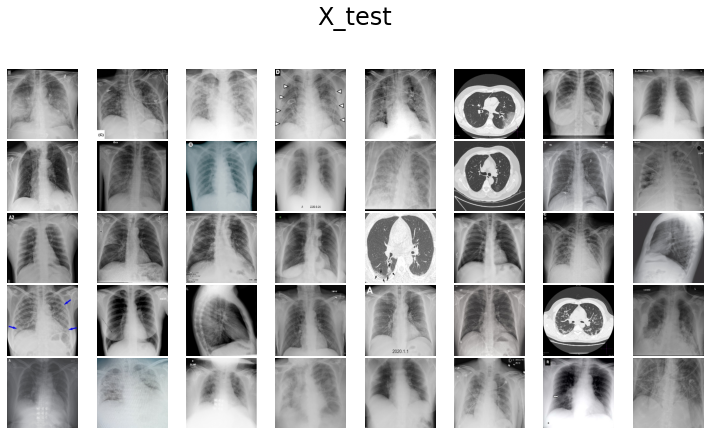

In [26]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [27]:
vggModel = VGG19(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False
    
model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

80150528/80134624 [==============================] - 7s 0us/step


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### **Training the model**

In [29]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10)

Epoch 1/10
23/23 [==============================] - 71s 3s/step - loss: 1.0069 - accuracy: 0.5758 - val_loss: 0.5838 - val_accuracy: 0.7340
Epoch 2/10
23/23 [==============================] - 72s 3s/step - loss: 0.6695 - accuracy: 0.6689 - val_loss: 0.4797 - val_accuracy: 0.7766
Epoch 3/10
23/23 [==============================] - 72s 3s/step - loss: 0.5333 - accuracy: 0.7540 - val_loss: 0.3469 - val_accuracy: 0.8723
Epoch 4/10
23/23 [==============================] - 73s 3s/step - loss: 0.4707 - accuracy: 0.7753 - val_loss: 0.3228 - val_accuracy: 0.8564
Epoch 5/10
23/23 [==============================] - 75s 3s/step - loss: 0.4459 - accuracy: 0.7859 - val_loss: 0.3732 - val_accuracy: 0.8511
Epoch 6/10
23/23 [==============================] - 73s 3s/step - loss: 0.4579 - accuracy: 0.7753 - val_loss: 0.2702 - val_accuracy: 0.8936
Epoch 7/10
23/23 [==============================] - 73s 3s/step - loss: 0.4045 - accuracy: 0.8178 - val_loss: 0.3346 - val_accuracy: 0.8883
Epoch 8/10
23/23 [==

### **Making Predicions**

In [30]:
y_pred = model.predict(X_test)

### Visulaizing First 10 predictions

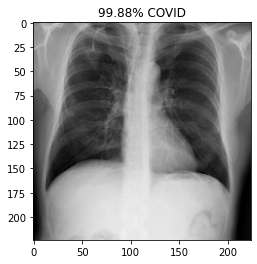

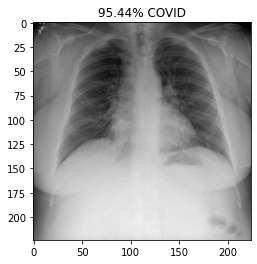

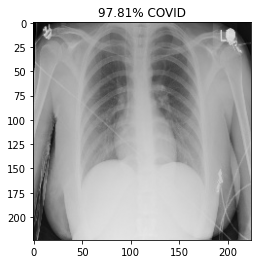

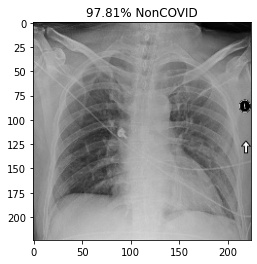

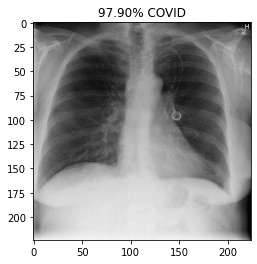

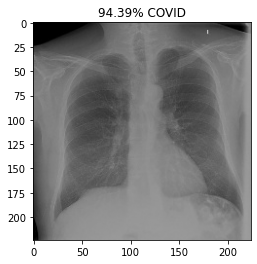

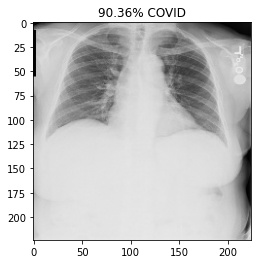

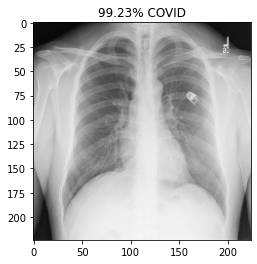

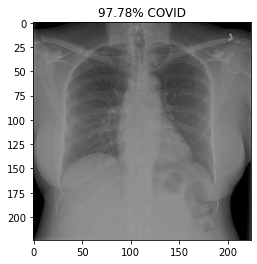

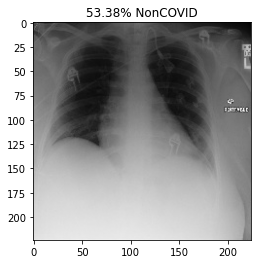

In [31]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [32]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83        87
           1       0.81      0.95      0.88       101

    accuracy                           0.86       188
   macro avg       0.87      0.85      0.85       188
weighted avg       0.87      0.86      0.85       188

